<a href="https://colab.research.google.com/github/kkmcgg/experiments/blob/main/kkmc_windFetch_NS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
# prompt: https://github.com/KennethTM/WindFetch.git has not setup file. can we simply pull it down to access the code

!git clone https://github.com/kkmcgg/WindFetch.git
%cd WindFetch


Cloning into 'WindFetch'...
remote: Enumerating objects: 120, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 120 (delta 7), reused 2 (delta 2), pack-reused 103 (from 1)
Receiving objects: 100% (120/120), 4.12 MiB | 7.80 MiB/s, done.
Resolving deltas: 100% (39/39), done.
/content/WindFetch/WindFetch


In [42]:
!pip install rasterio

In [43]:
!pip install GDAL

In [44]:
from osgeo import gdal

In [45]:
print(gdal)

<module 'osgeo.gdal' from '/usr/local/lib/python3.10/dist-packages/osgeo/gdal.py'>


In [46]:
!ls

kkmc_fetch_maybe_modified.ipynb  README.md   waterbody_test.py
kkmc_windFetch.ipynb		 test_files  WindFetch.py


In [47]:
import sys
print(sys.version)

3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]


In [48]:
!python waterbody_test.py

/content/WindFetch/WindFetch/waterbody_test.py:77: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, i+1)


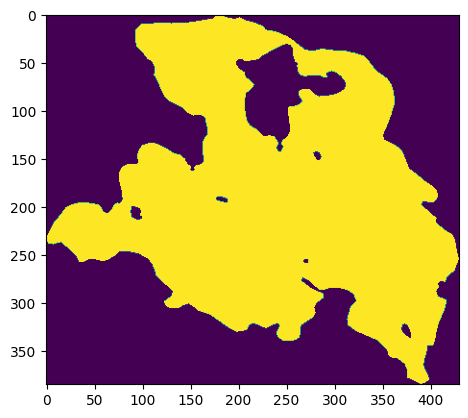

In [49]:
import matplotlib.pyplot as plt
f = plt.imread('/content/WindFetch/test_files/gurre_lake.tif')
plt.imshow(f)

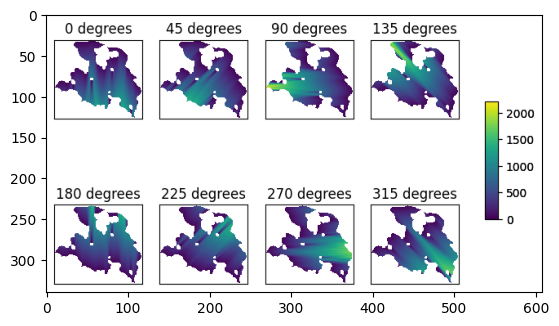

In [50]:
import matplotlib.pyplot as plt
f = plt.imread('/content/WindFetch/test_files/gurre_lake_fetch_minor.png')
plt.imshow(f)

Array shape: (256, 256)
Array data type: uint8


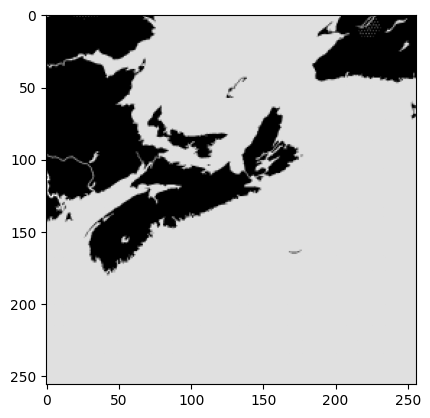

In [51]:
# pro tips!
# https://edward17.github.io/LayersCollection/#map=19/46.80112/9.83219&layers=1000
# https://tools.geofabrik.de/map/?type=Geofabrik_Standard&grid=1#6/44.7022/-61.6120


import requests
from PIL import Image
import numpy as np
from io import BytesIO

# Define the tile coordinates and zoom level
zoom = 5
tile_x = 10
tile_y = 11

# Construct the URL to fetch the tile from OpenStreetMap's standard tile server
# url = f"https://tile.openstreetmap.org/{zoom}/{tile_x}/{tile_y}.png"

url = f"https://a.basemaps.cartocdn.com/dark_nolabels/{zoom}/{tile_x}/{tile_y}.png"

# Set headers with a User-Agent
headers = {
    'User-Agent': 'MyApplication (myemail@example.com)'
}

# Fetch the tile
response = requests.get(url, headers=headers)
if response.status_code == 200:
    # Open the image from the response
    image = Image.open(BytesIO(response.content))

    # Convert the image to a NumPy array
    image_array = np.array(image)

    # Display the array shape and type
    print("Array shape:", image_array.shape)
    print("Array data type:", image_array.dtype)

    # Optionally, show the image using PIL
    # image.show()
    plt.imshow(image_array,cmap='gray')
else:
    print("Failed to retrieve the tile. Status code:", response.status_code)


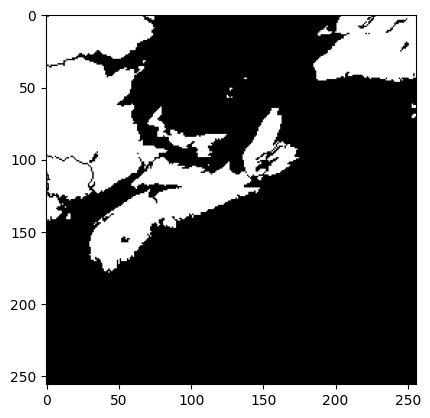

In [52]:
nsMask = np.where(image_array>2,0,1)
plt.imshow(nsMask,cmap='gray')

In [53]:
from WindFetch import Waterbody, Fetch

In [71]:
# prompt: safe nsMask as tif

from osgeo import gdal
import numpy as np

# Assuming nsMask is your NumPy array
# Create a new raster dataset
driver = gdal.GetDriverByName('GTiff')
dataset = driver.Create('nsMask.tif', nsMask.shape[1], nsMask.shape[0], 1, gdal.GDT_Byte)

# Write the array to the raster band
band = dataset.GetRasterBand(1)
band.WriteArray(1-nsMask)

# Set the NoData value
band.SetNoDataValue(0)

# Close the dataset
dataset = None

In [72]:
lake = Waterbody.read_waterbody('nsMask.tif', 1)

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:355: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


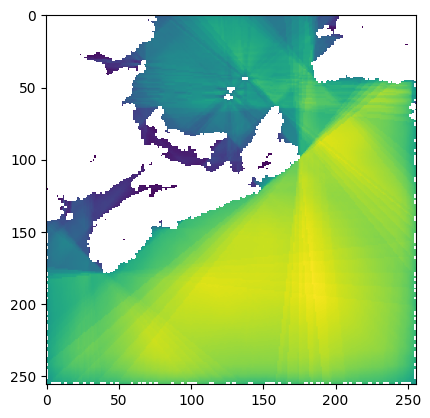

In [77]:
dirs = [0, 45, 90, 135, 180, 225, 270, 315]

#Fetch along main directions
fetch_main = lake.fetch(dirs)

#Summary statistics of calculated fetches
fetch_main_summary = fetch_main.summary(["min", "mean", "max"])

#Apply weighting to each direction
dirs_weights = [0.1, 0.3, 0.1, 0.2, 0, 0, 0.2, 0.1]

fetch_main_weight = fetch_main.weighting(dirs_weights)

#Calculated weighted mean
fetch_main_weight_mean = fetch_main_weight.summary(["mean"])

#Fetch along main directions each calculated as the average of 5 directions with a distance of 3 degrees
fetch_minor = lake.fetch(dirs, minor_directions = 5, minor_interval = 3)
print(fetch_minor)
#Write to file
fetch_minor.write_waterbody("nsMask_fetch_minor.png")

plt.imshow(fetch_minor.array.sum(axis=0), cmap='viridis')

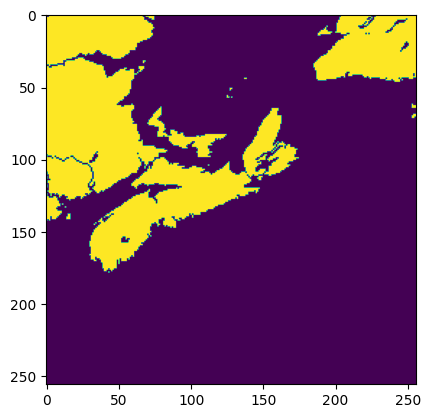

In [57]:
import matplotlib.pyplot as plt
f = plt.imread('/content/WindFetch/nsMask.tif')
plt.imshow(f)

In [58]:
import matplotlib.pyplot as plt
f = plt.imread('/content/WindFetch/nsMask_fetch_minor.tif')
plt.imshow(f)

ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 8


UnidentifiedImageError: cannot identify image file '/content/WindFetch/nsMask_fetch_minor.tif'